In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import sklearn
import warnings
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [119]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/car.data")

In [120]:
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [121]:
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class values"]


In [122]:
df['doors'] = df['doors'].replace(['5more'], '5')
df['persons'] = df['persons'].replace(['more'], '4')


# Convert categorical features to category type and encode them

In [123]:
for col in ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']:
    df[col] = df[col].astype('category')


# Convert categories to codes

In [124]:
for col in ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']:
    df[col] = df[col].cat.codes


# One-hot encode features

In [125]:
df = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

In [126]:
df.head()

,class values,buying_0,buying_1,buying_2,buying_3,maint_0,maint_1,maint_2,maint_3,doors_0,...,doors_2,doors_3,persons_0,persons_1,lug_boot_0,lug_boot_1,lug_boot_2,safety_0,safety_1,safety_2
0,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,False,True,False,False,True
1,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,False,True,True,False,False
2,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,True,False,False,True,False
3,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,True,False,False,False,True
4,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,True,False,True,False,False


In [127]:
df['class values'].unique()


array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

# Drop unnecessary columns

In [128]:
df = df.drop(['buying_3', 'maint_3', 'doors_3', 'persons_1', 'lug_boot_2', 'safety_2'], axis=1)

In [129]:
df.head()

,class values,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,lug_boot_0,lug_boot_1,safety_0,safety_1
0,unacc,False,False,False,False,False,False,True,False,False,True,False,False,False,False
1,unacc,False,False,False,False,False,False,True,False,False,True,False,False,True,False
2,unacc,False,False,False,False,False,False,True,False,False,True,False,True,False,True
3,unacc,False,False,False,False,False,False,True,False,False,True,False,True,False,False
4,unacc,False,False,False,False,False,False,True,False,False,True,False,True,True,False


# Encode target variable

In [130]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['class values'] = labelencoder.fit_transform(df['class values'])

In [131]:
x = df.drop(["class values"], axis=1)
y = df["class values"]

In [132]:
x.head()

,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,lug_boot_0,lug_boot_1,safety_0,safety_1
0,False,False,False,False,False,False,True,False,False,True,False,False,False,False
1,False,False,False,False,False,False,True,False,False,True,False,False,True,False
2,False,False,False,False,False,False,True,False,False,True,False,True,False,True
3,False,False,False,False,False,False,True,False,False,True,False,True,False,False
4,False,False,False,False,False,False,True,False,False,True,False,True,True,False


In [133]:
y.head()

,class values
0,2
1,2
2,2
3,2
4,2


In [134]:
y.unique()


array([2, 0, 3, 1])

# Split into 70% train, 15% validation, and 15% test sets

In [135]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

## OneR

In [136]:
class OneRClassifier:
    def __init__(self):
        self.rule = {}
        self.best_feature = None

    def fit(self, X, y):
        best_error = float('inf')

        for feature in X.columns:
            feature_rule = {}
            grouped = pd.DataFrame({'feature': X[feature], 'target': y}).groupby('feature')['target'].agg(lambda x: x.value_counts().idxmax())
            feature_rule = grouped.to_dict()

            y_pred = X[feature].map(feature_rule)
            error = sum(y_pred != y)

            if error < best_error:
                best_error = error
                self.rule = feature_rule
                self.best_feature = feature

    def predict(self, X):
        if not self.best_feature:
            raise ValueError("The model has not been trained yet!")
        return X[self.best_feature].map(self.rule)

In [137]:
def calculate_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true][pred] += 1
    return cm

def calculate_metrics(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    cm = calculate_confusion_matrix(y_true, y_pred, num_classes)
    total = cm.sum()
    accuracy = np.trace(cm) / total

    precisions = []
    recalls = []
    f1_scores = []
    for i in range(num_classes):
        tp = cm[i, i]
        fp = sum(cm[:, i]) - tp
        fn = sum(cm[i, :]) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'average_precision': avg_precision,
        'average_recall': avg_recall,
        'average_f1': avg_f1,
    }

In [138]:
model = OneRClassifier()
model.fit(x_train, y_train)

In [139]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [140]:
metrics = calculate_metrics(y_val.to_numpy(), y_val_pred.to_numpy())
metrics2 = calculate_metrics(y_test.to_numpy(), y_test_pred.to_numpy())

In [141]:
print("OneR Classifier Validation Metrics:")
print(f"Accuracy: {metrics['accuracy']:.2f}")
print("Confusion Matrix (Custom):")
print(metrics['confusion_matrix'])
print(f"Average Precision: {metrics['average_precision']:.2f}")
print(f"Average Recall: {metrics['average_recall']:.2f}")
print(f"Average F1-Score: {metrics['average_f1']:.2f}")

OneR Classifier Validation Metrics:
Accuracy: 0.69
Confusion Matrix (Custom):
[[  0   0  66   0]
 [  0   0   5   0]
 [  0   0 178   0]
 [  0   0  10   0]]
Average Precision: 0.17
Average Recall: 0.25
Average F1-Score: 0.20


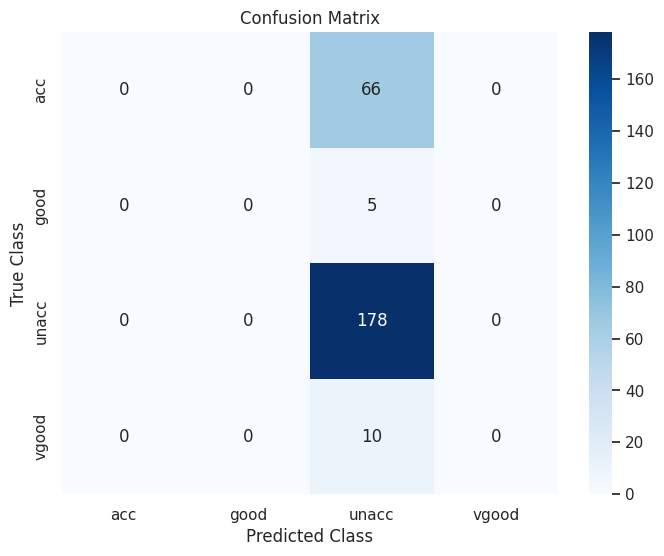

In [142]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

class_names = labelencoder.inverse_transform(range(len(np.unique(y_train))))

plot_confusion_matrix(metrics['confusion_matrix'], class_names)


In [143]:
print("OneR Classifier test Metrics:")
print(f"Accuracy: {metrics2['accuracy']:.2f}")
print("Confusion Matrix (Custom):")
print(metrics2['confusion_matrix'])
print(f"Average Precision: {metrics2['average_precision']:.2f}")
print(f"Average Recall: {metrics2['average_recall']:.2f}")
print(f"Average F1-Score: {metrics2['average_f1']:.2f}")


OneR Classifier test Metrics:
Accuracy: 0.70
Confusion Matrix (Custom):
[[  0   0  52   0]
 [  0   0  12   0]
 [  0   0 183   0]
 [  0   0  13   0]]
Average Precision: 0.18
Average Recall: 0.25
Average F1-Score: 0.21


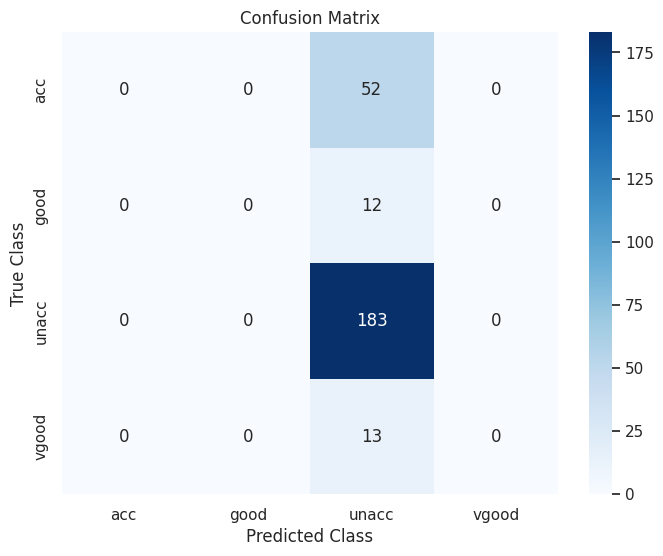

In [144]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

class_names = labelencoder.inverse_transform(range(len(np.unique(y_train))))

plot_confusion_matrix(metrics2['confusion_matrix'], class_names)


## ZeroR


In [145]:
majority_class = y_train.mode()[0]
y_val_pred_zeror = [majority_class] * len(y_val)
y_test_pred_zeror = [majority_class] * len(y_test)

In [146]:
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    corr_pred = np.sum(y_true == y_pred)

    total_pred = len(y_true)

    accuracy = corr_pred / total_pred

    return accuracy

In [147]:
def confusion_matrix(y_true, y_pred, labels=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))

    cm = np.zeros((len(labels), len(labels)), dtype=int)

    label_to_index = {label: idx for idx, label in enumerate(labels)}

    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = label_to_index[true_label]
        pred_idx = label_to_index[pred_label]
        cm[true_idx, pred_idx] += 1

    return cm

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [148]:
def precision_recall_f1(cm):
    epsilon = 1e-10
    precision = np.diag(cm) / (np.sum(cm, axis=0) + epsilon)
    recall = np.diag(cm) / (np.sum(cm, axis=1) + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    f1 = np.nan_to_num(f1)

    return precision, recall, f1, accuracy


def classification_report(y_true, y_pred, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))

    cm = confusion_matrix(y_true, y_pred, labels)

    precision, recall, f1, accuracy = precision_recall_f1(cm)

    report = "               precision    recall  f1-score   support\n\n"

    for idx, label in enumerate(labels):
        report += f"{label:>10}       {precision[idx]:.2f}      {recall[idx]:.2f}      {f1[idx]:.2f}       {np.sum(cm[idx]):>3}\n"

    macro_avg_precision = np.mean(precision)
    macro_avg_recall = np.mean(recall)
    macro_avg_f1 = np.mean(f1)
    report += f"\n    accuracy                           {accuracy:.2f}      {len(y_true)}\n"
    report += f"   macro avg       {macro_avg_precision:.2f}      {macro_avg_recall:.2f}      {macro_avg_f1:.2f}      {len(y_true)}\n"

    return report


In [149]:
val_accuracy = accuracy_score(y_val, y_val_pred_zeror)
test_accuracy = accuracy_score(y_test, y_test_pred_zeror)

print(f"ZeroR Validation Accuracy (Custom): {val_accuracy:.2f}")
print(f"ZeroR Test Accuracy (Custom): {test_accuracy:.2f}")


ZeroR Validation Accuracy (Custom): 0.69
ZeroR Test Accuracy (Custom): 0.70


In [150]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_test_pred_zeror, labels=labels)

report = classification_report(y_test, y_test_pred_zeror, labels=labels)
print("\nCustom Classification Report (Test Data):")
print(report)



Custom Classification Report (Test Data):
               precision    recall  f1-score   support

         0       0.00      0.00      0.00        52
         1       0.00      0.00      0.00        12
         2       0.70      1.00      0.83       183
         3       0.00      0.00      0.00        13

    accuracy                           0.70      260
   macro avg       0.18      0.25      0.21      260



Confusion Matrix:
[[  0   0  66   0]
 [  0   0   5   0]
 [  0   0 178   0]
 [  0   0  10   0]]


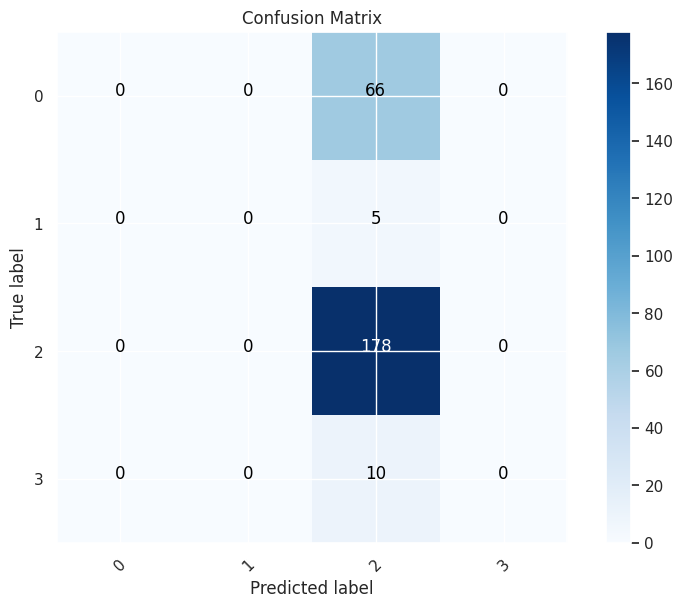

In [151]:
labels = np.unique(y_val)
cm = confusion_matrix(y_val, y_val_pred_zeror, labels=labels)

print("Confusion Matrix:")
print(cm)

plot_confusion_matrix(cm, labels=labels)

Confusion Matrix:
[[  0   0  52   0]
 [  0   0  12   0]
 [  0   0 183   0]
 [  0   0  13   0]]


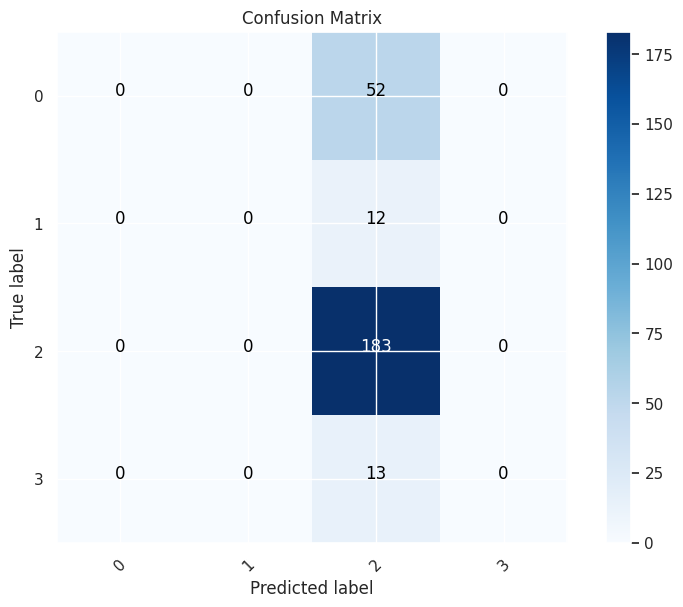

In [152]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_test_pred_zeror, labels=labels)

print("Confusion Matrix:")
print(cm)

plot_confusion_matrix(cm, labels=labels)

## K-Nearest-Neighbor Classifiers

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV

In [154]:
param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_knn = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_test_pred = best_knn.predict(x_test)
y_val_pred = best_knn.predict(x_val)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'distance'}


In [155]:
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)


Validation Accuracy: 0.9227799227799228
Test Accuracy: 0.9230769230769231


In [156]:
cm1 = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:")
print(cm1)

cm2 = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(cm2)

Validation Confusion Matrix:
[[ 55   0  10   1]
 [  3   2   0   0]
 [  4   0 174   0]
 [  2   0   0   8]]
Test Confusion Matrix:
[[ 47   1   4   0]
 [  5   6   0   1]
 [  2   0 181   0]
 [  3   4   0   6]]


In [157]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

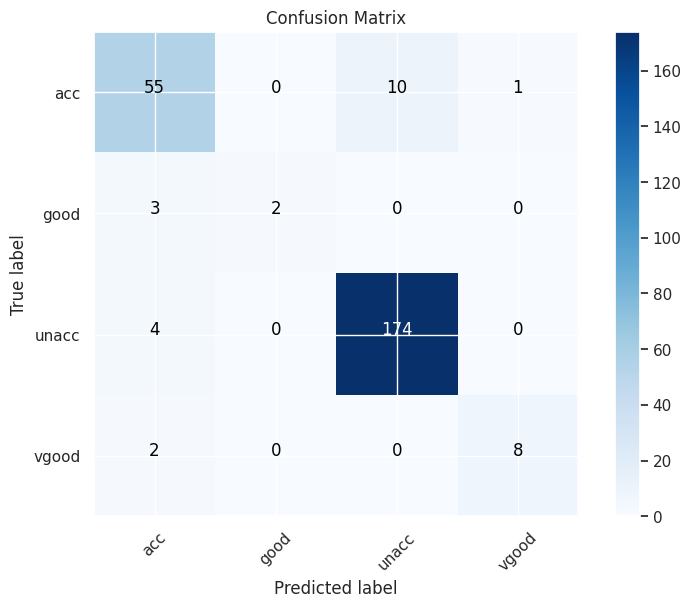

In [158]:
plot_confusion_matrix(cm1, labels=labelencoder.classes_)

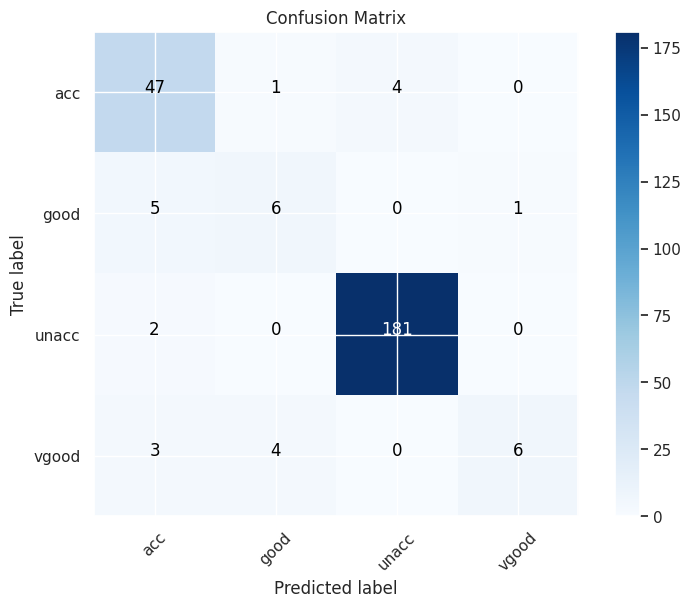

In [159]:
plot_confusion_matrix(cm2, labels=labelencoder.classes_)

In [160]:
val_report = classification_report(y_val, y_val_pred)
print("Validation Classification Report:")
print(val_report)

report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(report)


Validation Classification Report:
               precision    recall  f1-score   support

         0       0.86      0.83      0.85        66
         1       1.00      0.40      0.57         5
         2       0.95      0.98      0.96       178
         3       0.89      0.80      0.84        10

    accuracy                           0.92      259
   macro avg       0.92      0.75      0.81      259

Test Classification Report:
               precision    recall  f1-score   support

         0       0.82      0.90      0.86        52
         1       0.55      0.50      0.52        12
         2       0.98      0.99      0.98       183
         3       0.86      0.46      0.60        13

    accuracy                           0.92      260
   macro avg       0.80      0.71      0.74      260



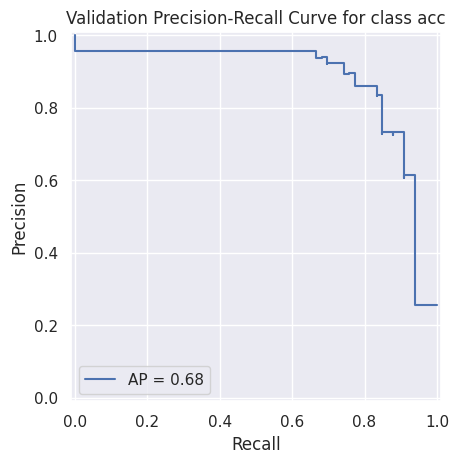

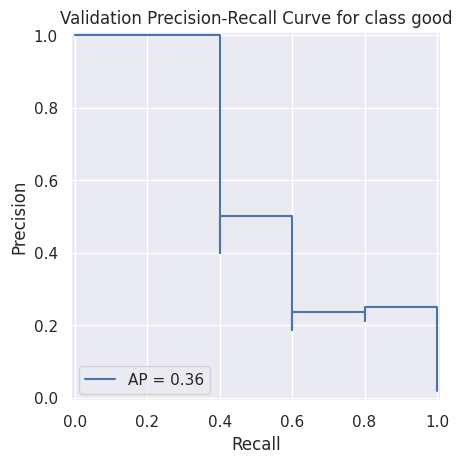

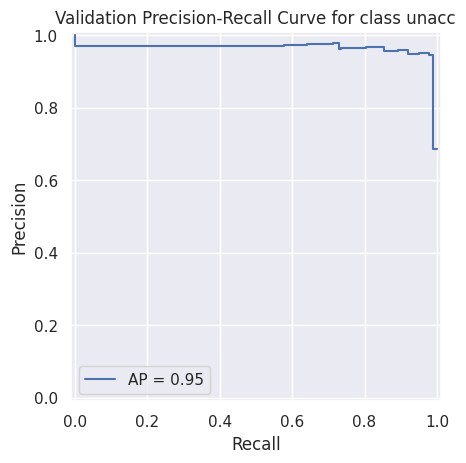

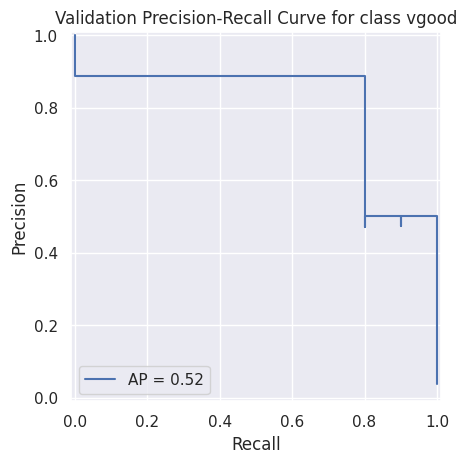

In [161]:
y_val_pred_prob = best_knn.predict_proba(x_val)

for i in range(len(labelencoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_val == i, y_val_pred_prob[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=np.mean(precision)).plot()
    plt.title(f'Validation Precision-Recall Curve for class {labelencoder.classes_[i]}')

plt.show()

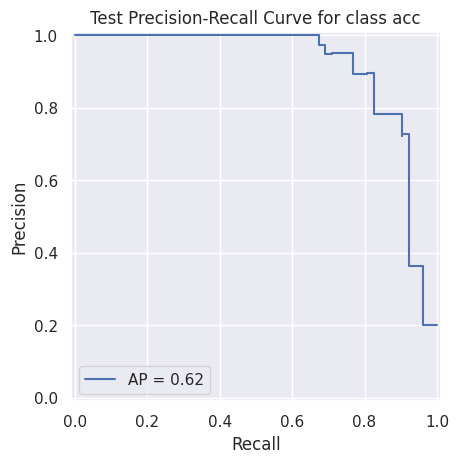

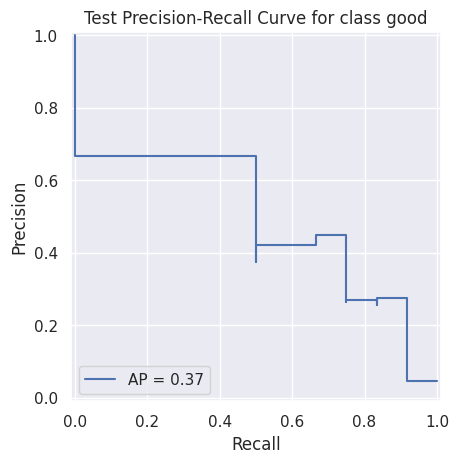

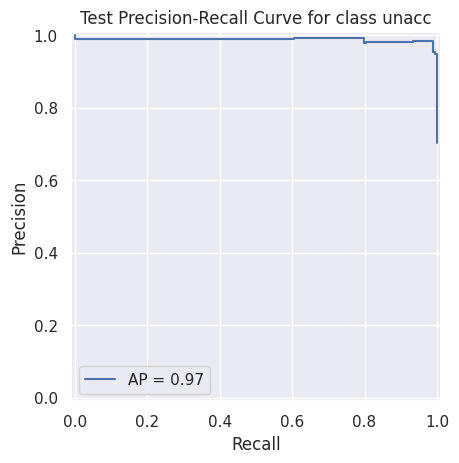

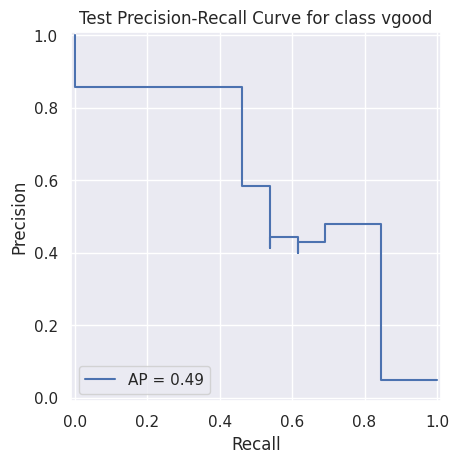

In [162]:
y_test_pred_prob = best_knn.predict_proba(x_test)

for i in range(len(labelencoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test == i, y_test_pred_prob[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=np.mean(precision)).plot()
    plt.title(f'Test Precision-Recall Curve for class {labelencoder.classes_[i]}')

plt.show()


## Naive Bayesian Classifier

In [163]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import PrecisionRecallDisplay

In [164]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

In [165]:
y_test_pred = nb.predict(x_test)
y_val_pred = nb.predict(x_val)

In [166]:
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

Test Accuracy: 0.676923076923077
Validation Accuracy: 0.7374517374517374


In [167]:
cm1 = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(cm1)

cm2 = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:")
print(cm2)

Test Confusion Matrix:
[[ 12  21   0  19]
 [  0   7   0   5]
 [ 14  11 149   9]
 [  0   5   0   8]]
Validation Confusion Matrix:
[[ 30  16   0  20]
 [  0   3   0   2]
 [ 13  10 149   6]
 [  0   1   0   9]]


In [168]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

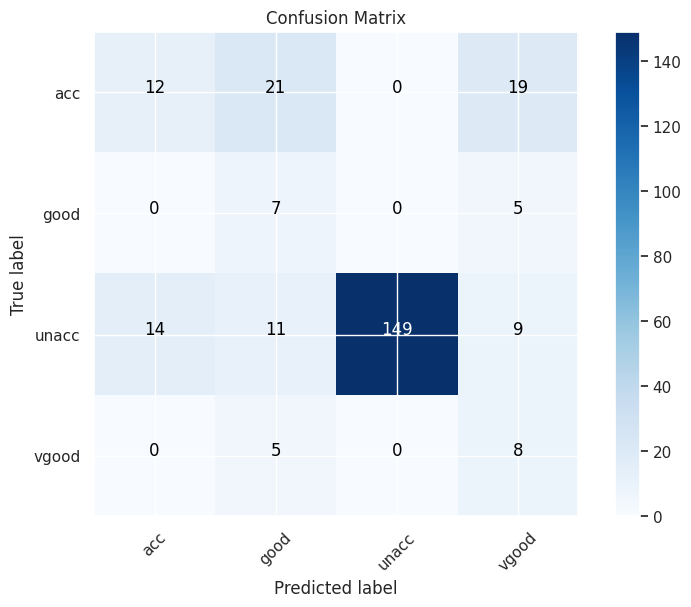

In [169]:
plot_confusion_matrix(cm1, labels=labelencoder.classes_)

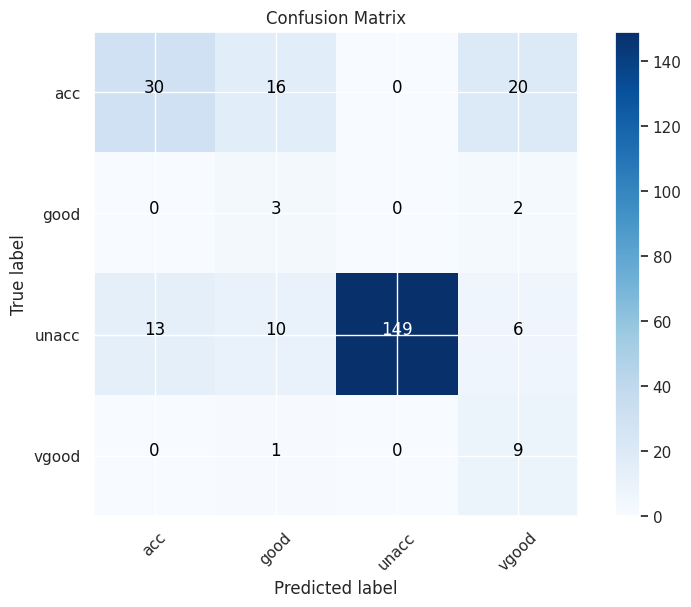

In [170]:
plot_confusion_matrix(cm2, labels=labelencoder.classes_)

In [171]:
test_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(test_report)
val_report = classification_report(y_val, y_val_pred)
print("Validation Classification Report:")
print(val_report)

Test Classification Report:
               precision    recall  f1-score   support

         0       0.46      0.23      0.31        52
         1       0.16      0.58      0.25        12
         2       1.00      0.81      0.90       183
         3       0.20      0.62      0.30        13

    accuracy                           0.68      260
   macro avg       0.45      0.56      0.44      260

Validation Classification Report:
               precision    recall  f1-score   support

         0       0.70      0.45      0.55        66
         1       0.10      0.60      0.17         5
         2       1.00      0.84      0.91       178
         3       0.24      0.90      0.38        10

    accuracy                           0.74      259
   macro avg       0.51      0.70      0.50      259



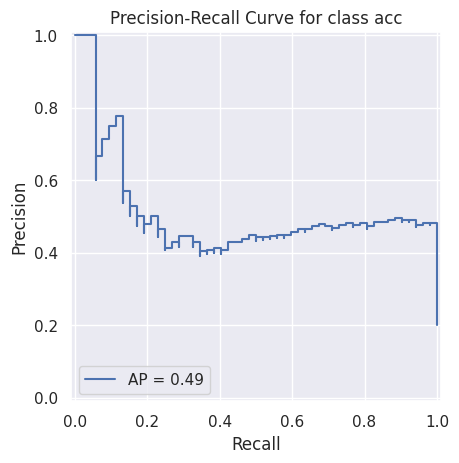

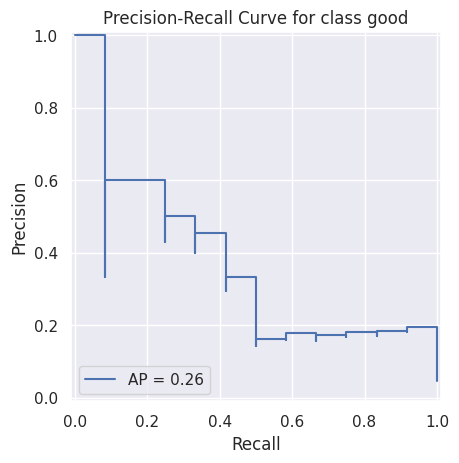

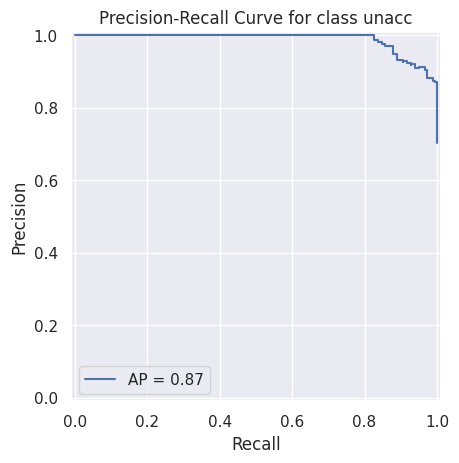

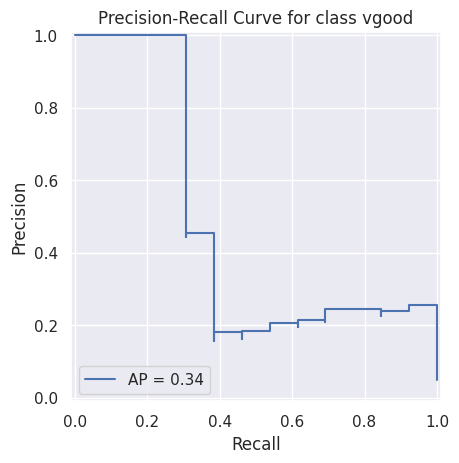

In [172]:
y_test_pred_prob = nb.predict_proba(x_test)

for i in range(len(labelencoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test == i, y_test_pred_prob[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=np.mean(precision)).plot()
    plt.title(f'Precision-Recall Curve for class {labelencoder.classes_[i]}')

plt.show()

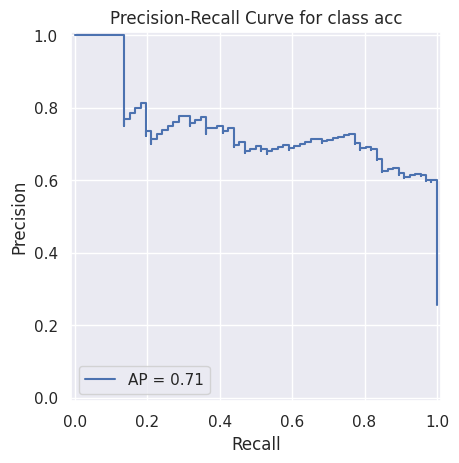

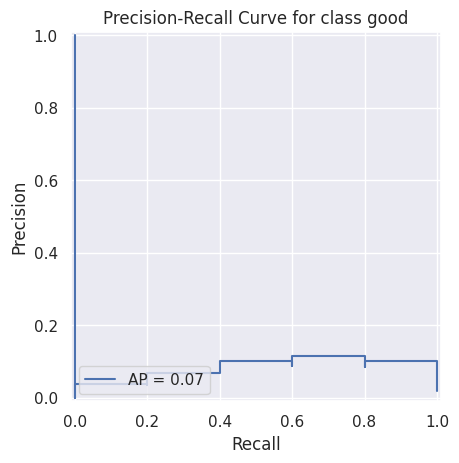

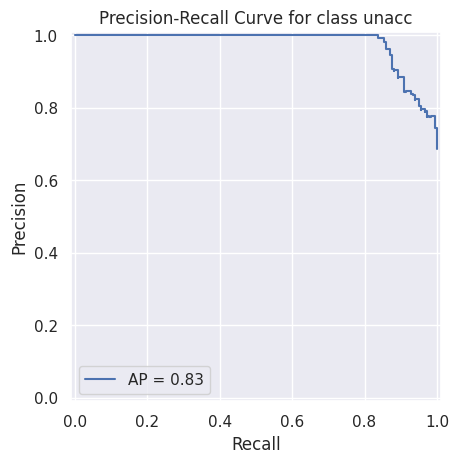

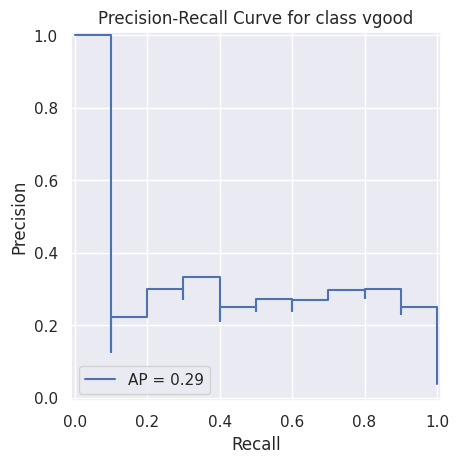

In [173]:
y_val_pred_prob = nb.predict_proba(x_val)

for i in range(len(labelencoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_val == i, y_val_pred_prob[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=np.mean(precision)).plot()
    plt.title(f'Precision-Recall Curve for class {labelencoder.classes_[i]}')

plt.show()

## Support vector machine (SVM)

In [174]:
from sklearn.svm import SVC
from sklearn.metrics import PrecisionRecallDisplay

In [175]:
# svm = SVC(kernel='linear', probability=True)
# svm.fit(x_train, y_train)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1]
}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_


In [176]:
# y_val_pred = svm.predict(x_val)
y_val_pred = best_model.predict(x_val)

In [177]:
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9768339768339769


In [178]:
val_cm = confusion_matrix(y_val, y_val_pred)
print("Validation Confusion Matrix:")
print(val_cm)


Validation Confusion Matrix:
[[ 63   1   1   1]
 [  1   3   0   1]
 [  1   0 177   0]
 [  0   0   0  10]]


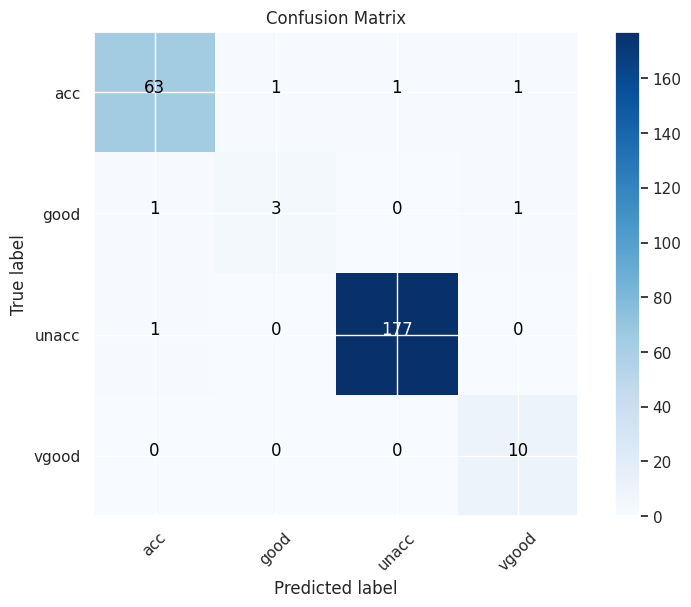

In [179]:
plot_confusion_matrix(val_cm, labels=labelencoder.classes_)


In [180]:
val_report = classification_report(y_val, y_val_pred)
print("Validation Classification Report:")
print(val_report)

Validation Classification Report:
               precision    recall  f1-score   support

         0       0.97      0.95      0.96        66
         1       0.75      0.60      0.67         5
         2       0.99      0.99      0.99       178
         3       0.83      1.00      0.91        10

    accuracy                           0.98      259
   macro avg       0.89      0.89      0.88      259



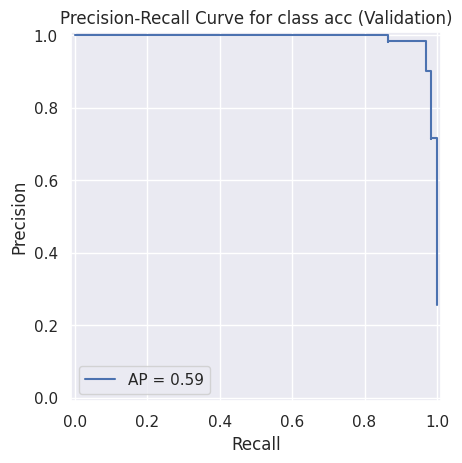

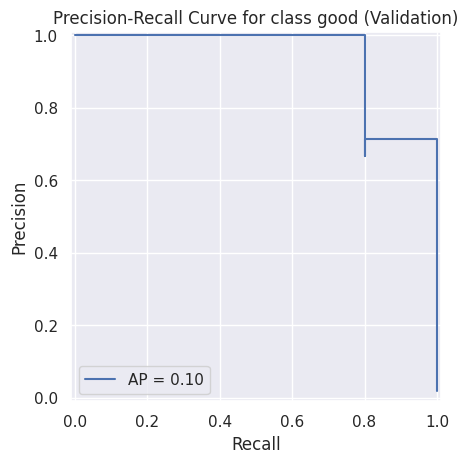

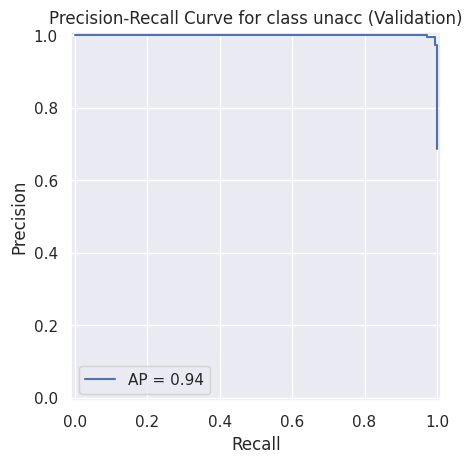

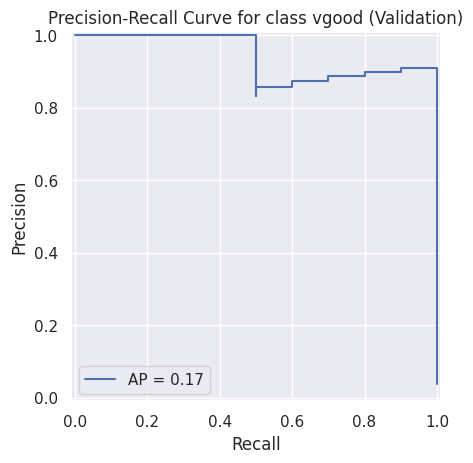

In [181]:
y_val_pred_prob = best_model.predict_proba(x_val)
for i in range(len(labelencoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_val == i, y_val_pred_prob[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=np.mean(precision)).plot()
    plt.title(f'Precision-Recall Curve for class {labelencoder.classes_[i]} (Validation)')

plt.show()

In [182]:
# y_test_pred = svm.predict(x_test)
y_test_pred = best_model.predict(x_test)


In [183]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.95


In [184]:
test_cm = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(test_cm)

Test Confusion Matrix:
[[ 47   3   1   1]
 [  2   8   0   2]
 [  2   0 181   0]
 [  0   2   0  11]]


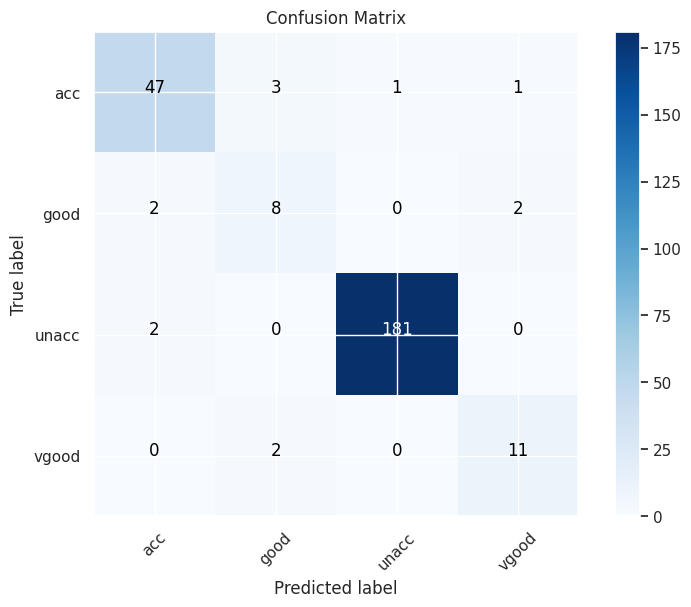

In [185]:
plot_confusion_matrix(test_cm, labels=labelencoder.classes_)

In [186]:
test_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(test_report)

Test Classification Report:
               precision    recall  f1-score   support

         0       0.92      0.90      0.91        52
         1       0.62      0.67      0.64        12
         2       0.99      0.99      0.99       183
         3       0.79      0.85      0.81        13

    accuracy                           0.95      260
   macro avg       0.83      0.85      0.84      260



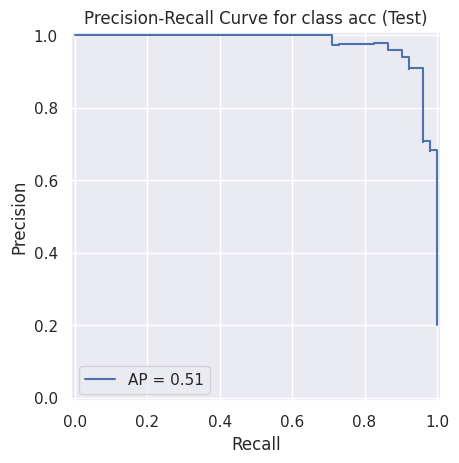

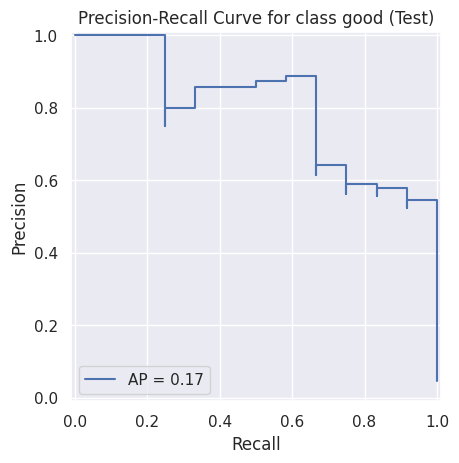

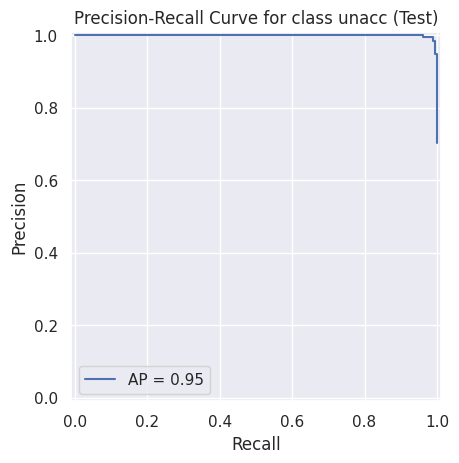

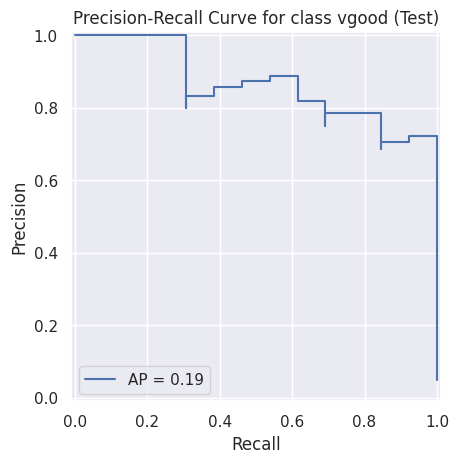

In [187]:
y_test_pred_prob = best_model.predict_proba(x_test)
for i in range(len(labelencoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test == i, y_test_pred_prob[:, i])
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=np.mean(precision)).plot()
    plt.title(f'Precision-Recall Curve for class {labelencoder.classes_[i]} (Test)')

plt.show()